In [155]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from util import onehot_by_group


csv_file = 'Actual-values-unnormalised-no-encoding.csv'
csv_file = pd.read_csv(csv_file, delimiter=',')

use_normalise = False
use_square = True
use_preposition = False
use_poly = True
use_grouping = False

In [158]:
true_output = csv_file[['Euclid Distance']].to_numpy()
longlat_col_names = ['LongF', 'LongG', 'LatF']
latlong = csv_file[longlat_col_names].to_numpy()

true_output_min = np.min(true_output, axis=0, keepdims=True)
true_output_max = np.max(true_output, axis=0, keepdims=True)
true_output_range = true_output_max - true_output_min
true_output_norm = (true_output - true_output_min) / true_output_range

latlong_min = np.min(latlong, axis=0, keepdims=True)
latlong_max = np.max(latlong, axis=0, keepdims=True)
latlong_range = latlong_max - latlong_min
latlong_norm = (latlong - latlong_min) / latlong_range

if use_normalise:
    X = latlong_norm
    if use_square:
        y = true_output_norm ** 2
    else:
        y = true_output_norm
else:
    X = latlong
    if use_square:
        y = true_output ** 2
    else:
        y = true_output

if use_poly:
    poly = PolynomialFeatures(degree=2)
    X = poly.fit_transform(X)
    xnames = poly.get_feature_names(longlat_col_names);
else:
    xnames = longlat_col_names

if use_preposition:
    if use_grouping:
        groups = (
            ('next to', 'near', 'adjacent to', 'outside'),
            ('beside', 'close to'),
            ('by', 'past', 'off', 'beyond'),
            ('along', 'alongside'),
            ('opposite', 'behind', 'above'),
            ('in', 'inside'),
            ('around', 'towards', 'at', 'on'),
            ('through', 'over', 'across')
        )
        group_names = ('Approximate 1', 'Approximate 2', 'Far', 'Alongness', 'Facing', 'In', '?', 'Throughness')

        raw_prepositions = csv_file['preposition'].to_numpy()
        result = onehot_by_group(raw_prepositions, groups, group_names)

        dummy_column_names = list(result.keys())
        dummy_column_values = np.ndarray((len(raw_prepositions), len(groups)), dtype=np.int32)
        for idx, column in enumerate(result.values()):
            dummy_column_values[:, idx] = column

    else:
        dummy_column = pd.get_dummies(csv_file['preposition'])
        dummy_column_values = dummy_column.values
        dummy_column_names = dummy_column.columns.to_list()
            
    X = np.concatenate([X, dummy_column_values], axis=1)
    xnames = np.concatenate([xnames, dummy_column_names]).tolist()


In [159]:
model = sm.OLS(y, X).fit()
print(model.summary(xname=xnames))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     2780.
Date:                Sun, 26 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:19:09   Log-Likelihood:                -8846.5
No. Observations:                 700   AIC:                         1.771e+04
Df Residuals:                     691   BIC:                         1.775e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
1               0.0121      0.006      1.995      

/Users/yfukuzaw/workspace/jupyter-plotly/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


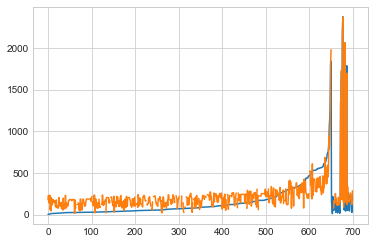

In [160]:
predicted_y_raw = est2.predict(poly_X).reshape((-1, 1))

if use_square:
    predicted_y_dequared = np.sqrt(predicted_y_raw)
else:
    predicted_y_dequared = predicted_y_raw

if use_normalise:
    predicted_y = predicted_y_dequared * true_output_range + true_output_min
else:
    predicted_y = predicted_y_dequared

fig = plt.figure()
ax = plt.axes()
ax.plot(true_output);
ax.plot(predicted_y);

In [114]:
pd.DataFrame(data = np.concatenate([true_output, predicted_y], axis = 1), columns=['true', 'predicted'])

,true,predicted
0,1.503179,176.615153
1,4.635376,228.495133
2,5.188077,167.765172
3,5.314202,137.318632
4,5.955651,231.856122
...,...,...
695,162.029546,245.498263
696,184.982611,236.242179
697,37.987507,125.440578
698,25.654329,122.452766
